Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<class 'numpy.ndarray'>


SystemExit: 0

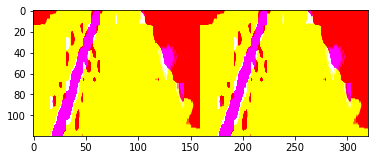

In [123]:
#import argparse
#import fnmatch
import json
#import os
import base64
import datetime
from io import BytesIO
from PIL import Image
import sys
import numpy as np
import matplotlib.pyplot as plt

# convert image array to PIL image, to see if we can concatenate them
# from PIL import Image
from matplotlib import cm


def GetSteeringFromtcpflow(filename):
    """
    Get a tcpflow log and extract steering values obtained from network communication between
    sim and prediction engine (predict_client.py)
    Inputs
        filename: string, name of tcpflow log
    Returns
        sa: list of arrays, steering angle predicton and actual value tuple.
    """
    # open file
    sa = []
    # initialize prediction
    pred = ''
    f = open(filename, "r")
    file = f.read()
    try:
        #readline = f.read()
        lines = file.splitlines()
        for line in lines:
            # print(line)
            start = line.find('{')
            if(start == -1):
                continue
            jsonstr = line[start:]
            # print(jsonstr)
            jsondict = json.loads(jsonstr)
            if "steering" in jsondict:
                # predicted
                pred = jsondict['steering']
            if "steering_angle" in jsondict:
                # actual
                act = jsondict['steering_angle']
                # save pair, only keep last pred in case two were send as it does happen i.e.:
                # 127.000.000.001.59460-127.000.000.001.09091: {"msg_type": "control", "steering": "-0.071960375", "throttle": "0.08249988406896591", "brake": "0.0"}
                # 127.000.000.001.59460-127.000.000.001.09091: {"msg_type": "control", "steering": "-0.079734944", "throttle": "0.08631626516580582", "brake": "0.0"}
                # 127.000.000.001.09091-127.000.000.001.59460: {"msg_type":"telemetry","steering_angle":-0.07196037,(...)
                if(len(pred) > 0):
                    sa.append([float(pred), act])
                    pred = '' # need to save this image

                    imgString = jsondict["image"]
                    image = Image.open(BytesIO(base64.b64decode(imgString)))

                    img_arr = np.asarray(image, dtype=np.float32)
                      
                    img_arr_proc = preprocess(img_arr)
                    img_arr = crop(img_arr)
                    img_arr = resize(img_arr)
                    # something happens here which "fixes" the image, i.e.
                    img_arr = rgb2yuv(img_arr)
                    #im = Image.fromarray(np.uint8(cm.gist_earth(img_arr)))
                    #stitch = stitchImages(img_arr, img_arr_proc, 160, 120)
                    #print(img_arr_proc.shape)
                    #print(type(image))
                    # plt.imshow(img_arr_proc)
                    print(type(img_arr))
                    myconc = np.concatenate((img_arr_proc, img_arr), axis = 1)
                    # plt.imshow(img_arr)
                    plt.imshow(myconc)
                    # print(image.size[0])
                    sys.exit(0)
    except Exception as e:
        print("Exception raise: " + str(e))
    # file should be automatically closed but will close for good measure
    f.close()
    return sa

sa = GetSteeringFromtcpflow('/tmp/tcpflow.log')

In [52]:
def stitchImages(a, b, w, h):
    """
    Stitch two images together side by side
    Inputs
        a, b: floating point image arrays
        w, h: integer width and height dimensions
    Output
        c: floating point stitched image array
    """
    # https://stackoverflow.com/questions/30227466/combine-several-images-horizontally-with-python
    total_width = w * 2
    max_height = h
    # convert to PIL image to paste
    a = Image.fromarray(a.astype('uint8'), 'RGB')
    b = Image.fromarray(b.astype('uint8'), 'YCbCr')

    new_im = Image.new('RGB', (total_width, max_height))
    new_im.paste(a, (0,0))
    new_im.paste(b, (w,0))
    # convert back to float array
    return new_im # np.asarray(new_im, dtype=np.float32) # new_im
    

In [124]:
myimg = np.asarray([[[1,1,1], [1,1,1], [1,1,1]],
                    [[1,1,1], [1,1,1], [1,1,1]],
                    [[1,1,1], [1,1,1], [1,1,1]]])

    
myimg2 = np.asarray([[[2,2,2], [2,2,2], [2,2,2]],
                    [[2,2,2], [2,2,2], [2,2,2]],
                    [[2,2,2], [2,2,2], [2,2,2]]])

myimg3 = np.asarray([[[1,1,1], [1,1,1], [1,1,1]],
                    [[1,1,1], [1,1,1], [1,1,1]],
                    [[1,1,1], [1,1,1], [1,1,1]],
                    [[2,2,2], [2,2,2], [2,2,2]],
                    [[2,2,2], [2,2,2], [2,2,2]],
                    [[2,2,2], [2,2,2], [2,2,2]]])

myimg4 = np.asarray([[[1,1,1], [1,1,1], [1,1,1],[2,2,2], [2,2,2], [2,2,2]],
                    [[1,1,1], [1,1,1], [1,1,1],[2,2,2], [2,2,2], [2,2,2]],
                    [[1,1,1], [1,1,1], [1,1,1],[2,2,2], [2,2,2], [2,2,2]]])

print(myimg.shape)
print(myimg2.shape)
print(myimg3.shape)
print(myimg4.shape)
# np.append(myimg, myimg2, axis=0)

import numpy as np
myconc = np.concatenate((myimg, myimg2), axis = 1)
myconc.shape



(3, 3, 3)
(3, 3, 3)
(6, 3, 3)
(3, 6, 3)


(3, 6, 3)

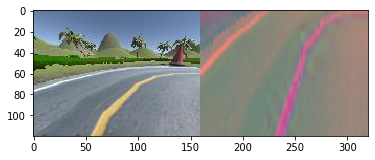

In [127]:
# quick test, can we concatenate if we read from disk?
myimg = load_image('../dataset/unity/jungle1/log/logs_Sat_Nov__7_11_11_06_2020/10000_cam-image_array_.jpg')

myprocimg = preprocess(myimg)
myconc = np.concatenate((myimg, myprocimg), axis = 1)
plt.imshow(myconc)


In [4]:
import cv2, os
import numpy as np
import matplotlib.image as mpimg

IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS = 160, 120, 3
# IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS = 66, 200, 3
# IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS = 120, 160, 3
INPUT_SHAPE = (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)
# Dimensions expected by network
IMAGE_WIDTH_NET, IMAGE_HEIGHT_NET = 160, 120


def load_image(image_path):
    """
    Load RGB images from a file
    """
    return mpimg.imread(image_path)


def crop(image):
    """
    Crop the image (removing the sky at the top and the car front at the bottom)
    """
    return image[60:-25, :, :] # remove the sky and the car front


def resize(image):
    """
    Resize the image to the input shape used by the network model
    """
    return cv2.resize(image, (IMAGE_WIDTH_NET, IMAGE_HEIGHT_NET), cv2.INTER_AREA)


def rgb2yuv(image):
    """
    Convert the image from RGB to YUV (This is what the NVIDIA model does)
    """
    return cv2.cvtColor(image, cv2.COLOR_RGB2YUV)


def preprocess(image):
    """
    Combine all preprocess functions into one
    """
    image = crop(image)
    image = resize(image)
    image = rgb2yuv(image)
    return image


def choose_image(data_dir, center, left, right, steering_angle):
    """
    Randomly choose an image from the center, left or right, and adjust
    the steering angle.
    """
    choice = np.random.choice(3)
    if choice == 0:
        return load_image(data_dir, left), steering_angle + 0.2
    elif choice == 1:
        return load_image(data_dir, right), steering_angle - 0.2
    return load_image(data_dir, center), steering_angle


def random_flip(image, steering_angle):
    """
    Randomly flipt the image left <-> right, and adjust the steering angle.
    """
    if np.random.rand() < 0.5:
        image = cv2.flip(image, 1)
        steering_angle = -steering_angle
    return image, steering_angle


def random_translate(image, steering_angle, range_x, range_y):
    """
    Randomly shift the image virtially and horizontally (translation).
    """
    trans_x = range_x * (np.random.rand() - 0.5)
    trans_y = range_y * (np.random.rand() - 0.5)
    steering_angle += trans_x * 0.002
    trans_m = np.float32([[1, 0, trans_x], [0, 1, trans_y]])
    height, width = image.shape[:2]
    image = cv2.warpAffine(image, trans_m, (width, height))
    return image, steering_angle


def random_shadow(image):
    """
    Generates and adds random shadow
    """
    # (x1, y1) and (x2, y2) forms a line
    # xm, ym gives all the locations of the image
    x1, y1 = IMAGE_WIDTH * np.random.rand(), 0
    x2, y2 = IMAGE_WIDTH * np.random.rand(), IMAGE_HEIGHT
    # could this be a bug?
    xm, ym = np.mgrid[0:IMAGE_HEIGHT, 0:IMAGE_WIDTH]
    # xm, ym = np.mgrid[0:IMAGE_WIDTH, 0:IMAGE_HEIGHT]
    
    # mathematically speaking, we want to set 1 below the line and zero otherwise
    # Our coordinate is up side down.  So, the above the line: 
    # (ym-y1)/(xm-x1) > (y2-y1)/(x2-x1)
    # as x2 == x1 causes zero-division problem, we'll write it in the below form:
    # (ym-y1)*(x2-x1) - (y2-y1)*(xm-x1) > 0
    mask = np.zeros_like(image[:, :, 1])
    mask[(ym - y1) * (x2 - x1) - (y2 - y1) * (xm - x1) > 0] = 1

    # choose which side should have shadow and adjust saturation
    cond = mask == np.random.randint(2)
    s_ratio = np.random.uniform(low=0.2, high=0.5)

    # adjust Saturation in HLS(Hue, Light, Saturation)
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    hls[:, :, 1][cond] = hls[:, :, 1][cond] * s_ratio
    return cv2.cvtColor(hls, cv2.COLOR_HLS2RGB)


def random_brightness(image):
    """
    Randomly adjust brightness of the image.
    """
    # HSV (Hue, Saturation, Value) is also called HSB ('B' for Brightness).
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    ratio = 1.0 + 0.4 * (np.random.rand() - 0.5)
    hsv[:,:,2] =  hsv[:,:,2] * ratio
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)


def augment(image, steering_angle, range_x=100, range_y=10):
    """
    Generate an augumented image and adjust steering angle.
    (The steering angle is associated with the center image)
    """
    # resize - we start with assumed image capture size
    image = cv2.resize(image, (320,160), cv2.INTER_AREA)
    # image = cv2.resize(image, (IMAGE_WIDTH, IMAGE_HEIGHT), cv2.INTER_AREA)
    image, steering_angle = random_flip(image, steering_angle)
    image, steering_angle = random_translate(image, steering_angle, range_x, range_y)
    image = random_shadow(image)
    image = random_brightness(image)
    return image, steering_angle


def batch_generator(data_dir, image_paths, steering_angles, batch_size, is_training):
    """
    Generate training image give image paths and associated steering angles
    """
    images = np.empty([batch_size, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS])
    steers = np.empty(batch_size)
    while True:
        i = 0
        for index in np.random.permutation(image_paths.shape[0]):
            center, left, right = image_paths[index]
            steering_angle = steering_angles[index]
            # argumentation
            if is_training and np.random.rand() < 0.6:
                image, steering_angle = augument(data_dir, center, left, right, steering_angle)
            else:
                image = load_image(data_dir, center) 
            # add the image and steering angle to the batch
            images[i] = preprocess(image)
            steers[i] = steering_angle
            i += 1
            if i == batch_size:
                break
        yield images, steers

In [5]:
# Steering angle predictions by model 20201107210627_nvidia1.h5
def plotSteering(p,g,n):
    """
    Plot 
    Inputs
        p: array of floats, steering angle prediction
        g: array of floats, steering angle ground truth.
        n: float, normalization constant
    Output
    """
    import matplotlib.pyplot as plt

    plt.rcParams["figure.figsize"] = (18,3)

    plt.plot(p*n, label="model")
    plt.plot(g*n, label="simulator")

    plt.ylabel('Steering angle')
    # Set a title of the current axes.
    plt.title('Predicted and actual steering angles: SDSandbox simulator and model 20201107210627_nvidia1.h5')
    # show a legend on the plot
    plt.legend()
    # Display a figure.
    # horizontal grid only
    plt.grid(axis='y')
    # set limit
    plt.xlim([-5,len(sarr)+5])
    # invert axis so if seen sideways plot corresponds to direction of steering wheel
    plt.gca().invert_yaxis()
    plt.show()

p = sarr[:,0]
g = sarr[:,1]
n = 25 # 25 frames per second
plotSteering(p,g,n)

NameError: name 'sarr' is not defined

$ g_s(p,g) = \frac{\sum_i^N \lvert p(i)-g(i) \rvert }{N} \times n_c $ 

In [2]:
def gos(p, g, n):
    """
    Calculate the goodness-of-steer between a prediction and a ground truth array.
    Inputs
        p: array of floats, steering angle prediction
        g: array of floats, steering angle ground truth.
        n: float, normalization constant
    Output
        gos: float, average of absolute difference between ground truth and prediction arrays
    """
    # todo add type assertion
    assert len(p) == len(g), "Arrays must be of equal length"
    return sum(abs(p - g)) / len(p) * n

p = sarr[:,0]
g = sarr[:,1]

sterr = gos(p,g, 25)

print("Goodness of steer: {:.2f}".format(sterr))



NameError: name 'sarr' is not defined

In [2]:
import os
path = '~/git/sdsandbox/dataset/ford/2017-08-04-V2-Log1-Center'
for root, dirnames, filenames in os.walk(path):
    print(os.path.join(root, filename))